In [1]:
import pandas as pd
import numpy as np
import datetime
import holidays
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from hyperopt import Trials, STATUS_OK, tpe

from hyperas import optim
from hyperas.distributions import choice, uniform
from tensorflow.python.keras import backend as K

Using TensorFlow backend.


In [2]:
dati = pd.read_csv(r'Dati_PUN_17_19.csv', parse_dates = ['Data'])
sinusoidi = pd.read_csv(r'sinusoidi.csv')

dati['Giorno'] = dati['Data'].apply(lambda x: x.date().strftime('%A'))

def get_holiday(row):
    row = row.date()
    iatly_holidays = holidays.Italy(years = [2017, 2018, 2019])
    if row in iatly_holidays:
        return(1)
    else:
        return(0)    

dati['Giorno_Vacanza'] = dati['Data'].apply(get_holiday)

dummies = pd.get_dummies(dati['Giorno'])

frames = [dati, dummies, sinusoidi]

dati = pd.concat(frames, axis = 1)

dati = dati.drop(columns = ['Giorno'])

In [3]:
np.random.seed(7)

In [4]:
dati_val = np.array(dati['PUN'].values).reshape(-1, 1)

In [5]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dati_val = scaler.fit_transform(dati_val)

Train = dati_val[:26112]
Test = dati_val[26112:]

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

def get_holiday(row):
    row = row.date()
    iatly_holidays = holidays.Italy(years = [2017, 2018, 2019])
    if row in iatly_holidays:
        return(1)
    else:
        return(0)    

look_back = 1
trainX, trainY = create_dataset(Train, look_back)
testX, testY = create_dataset(Test, look_back)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics = ['mae'])
model.fit(trainX, trainY, epochs=4, batch_size=2, verbose=2)

In [6]:
def data():
    dati = pd.read_csv(r'df_prova.csv', parse_dates = ['Data'])
    dati_val = np.array(dati['PUN'].values).reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    dati_val = scaler.fit_transform(dati_val)
    Train = dati_val[:26112]
    Test = dati_val[26112:]
    look_back = 1
    dataX, dataY = [], []
    
    for i in range(len(Train)-look_back):
        a = Train[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(Train[i + look_back, 0])
        
    trainX = np.array(dataX)
    trainY = np.array(dataY)
    
    dataX, dataY = [], []
    
    for i in range(len(Test)-look_back):
        a = Test[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(Test[i + look_back, 0])
    
    testX = np.array(dataX)
    testY = np.array(dataY)
    
    
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    return(trainX, trainY, testX, testY)

In [7]:
def create_model(trainX, trainY, testX, testY):
    model = Sequential()
    model.add(LSTM(4, input_shape=(1, look_back)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error',
                 optimizer={{choice(['rmsprop', 'adam', 'sgd'])}},
                 metrics = ['mae'])
    results = model.fit(trainX, trainY, epochs=10, batch_size={{choice([2, 4, 6, 32, 64, 128])}}, 
                        verbose=2)
    validation_mae = np.amax(results.history['mae'])
    print('Best validation mae of epoch:', validation_mae)
    return {'loss': validation_mae, 'status': STATUS_OK, 'model': model}

In [8]:
best_run, best_model = optim.minimize(model=create_model,
                                      data = data,
                                      algo=tpe.suggest,
                                      max_evals=5,
                                      trials=Trials(),
                                      notebook_name='LSTM')

>>> Imports:
#coding=utf-8

try:
    import pandas as pd
except:
    pass

try:
    import numpy as np
except:
    pass

try:
    import datetime
except:
    pass

try:
    import holidays
except:
    pass

try:
    import math
except:
    pass

try:
    from keras.models import Sequential
except:
    pass

try:
    from keras.layers import Dense
except:
    pass

try:
    from keras.layers import LSTM
except:
    pass

try:
    from sklearn.preprocessing import MinMaxScaler
except:
    pass

try:
    from sklearn.metrics import mean_squared_error
except:
    pass

try:
    from sklearn.metrics import mean_absolute_error
except:
    pass

try:
    import matplotlib.pyplot as plt
except:
    pass

try:
    from sklearn.model_selection import train_test_split
except:
    pass

try:
    from hyperopt import Trials, STATUS_OK, tpe
except:
    pass

try:
    from hyperas import optim
except:
    pass

try:
    from hyperas.distributions import choice, uniform
except:
    pass

try:
    from

In [9]:
print("Best performing model chosen hyper-parameters:")
print(best_run)

Best performing model chosen hyper-parameters:
{'batch_size': 1, 'optimizer': 0}


In [10]:
trainX, trainY, testX, testY = data()

In [11]:
trainPredict = best_model.predict(trainX)
testPredict = best_model.predict(testX)

In [12]:
trainPredict = scaler.inverse_transform(trainPredict)

trainY = scaler.inverse_transform([trainY])

testPredict = scaler.inverse_transform(testPredict)

testY = scaler.inverse_transform([testY])

In [13]:
trainMAE = (mean_absolute_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f MAE' % (trainMAE))
testMAE = (mean_absolute_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f MAE' % (testMAE))

Train Score: 3.76 MAE
Test Score: 2.92 MAE


In [14]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [15]:
trainMAPE = mean_absolute_percentage_error(trainY[0], trainPredict[:,0])
print('Train Score: %.2f MAPE' % (trainMAPE))
testMAPE = mean_absolute_percentage_error(testY[0], testPredict[:,0])
print('Test Score: %.2f MAPE' % (testMAPE))

Train Score: 6.85 MAPE
Test Score: 10.49 MAPE


In [16]:
dftrain = pd.DataFrame({'TrainPredict': trainPredict[:,0], 'TrainY':trainY[0]})
dftest = pd.DataFrame({'TestPredict': testPredict[:,0], 'TestY':testY[0]})

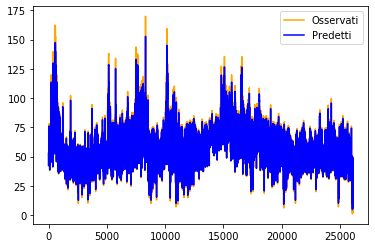

In [17]:
plt.plot('TrainY', color = "orange", data = dftrain, label = 'Osservati')
plt.plot('TrainPredict', color = "blue", data = dftrain, label = 'Predetti');
plt.legend()

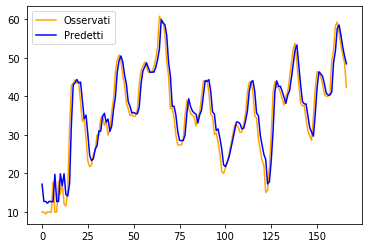

In [18]:
plt.plot('TestY', color = "orange", data = dftest, label = 'Osservati')
plt.plot('TestPredict', color = "blue", data = dftest, label = 'Predetti');
plt.legend()